In [1]:
#import pydicom
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
from collections import defaultdict




In [2]:
src_folder = "/content/drive/MyDrive/annotations"
dst_folder = "/content/annotations"

print("Copying files to local storage...")
shutil.copytree(src_folder, dst_folder)
print("Copy complete!")

Copying files to local storage...
Copy complete!


In [90]:

# Custom normalization transform
class NormalizeToMinusOneOne:
    """Custom transform to normalize image tensors to [-1, 1]"""
    def __call__(self, tensor):
        return tensor * 2 - 1  # Map [0, 1] to [-1, 1]

class HeartDataset(Dataset):
    def __init__(self, root_dir, transform=None, crop_percentage=0.7, subset_indices=None, image_paths=None, labels=None):
        """
        Args:
            root_dir (str): Root directory containing subfolders of views.
            transform (callable, optional): Transform to be applied on an image.
            crop_percentage (float): Percentage of the image to crop around the center.
            subset_indices (list): Optional list of indices to use for this subset.
            image_paths (list): Optional list of pre-split image paths.
            labels (list): Optional list of pre-split labels.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.crop_percentage = crop_percentage

        if image_paths and labels:
            self.image_paths = image_paths
            self.labels = labels
        else:
            # Load all image paths and labels
            self.image_paths = []
            self.labels = []
            self.classes = []

            for idx, view_folder in enumerate(sorted(os.listdir(root_dir))):
                view_path = os.path.join(root_dir, view_folder, "processed_resized_224")
                if os.path.isdir(view_path):
                    self.classes.append(view_folder)
                    for img_name in os.listdir(view_path):
                        if img_name.endswith(".jpg"):
                            self.image_paths.append(os.path.join(view_path, img_name))
                            self.labels.append(idx - 1)

        if subset_indices is not None:
            self.image_paths = [self.image_paths[i] for i in subset_indices]
            self.labels = [self.labels[i] for i in subset_indices]

    def __len__(self):
        return len(self.image_paths)

    def center_crop(self, image):
        """Apply center crop to the image based on crop_percentage."""
        width, height = image.size
        crop_width = int(width * self.crop_percentage)
        crop_height = int(height * self.crop_percentage)
        left = (width - crop_width) // 2
        top = (height - crop_height) // 2
        right = left + crop_width
        bottom = top + crop_height
        return image.crop((left, top, right, bottom))

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        dicom_id = os.path.basename(img_path).split(".")[0]

        # Load and convert to grayscale
        image = Image.open(img_path).convert("L")

        # Apply center crop
        image = self.center_crop(image)

        # Convert grayscale back to RGB for ResNet compatibility
        image = image.convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label, dicom_id

    @staticmethod
    def split_by_dicom(dataset, test_size=0.15, valid_size=0.15, random_state=42):
        """
        Splits the dataset by DICOM ID (extracted from file names).
        Ensures all slices from the same DICOM stay together.
        """
        dicom_to_files = defaultdict(list)
        dicom_to_labels = defaultdict(list)

        # Group files by DICOM ID
        for img_path, label in zip(dataset.image_paths, dataset.labels):
            filename = os.path.basename(img_path)
            dicom_id = filename.split("_")[0]
            dicom_to_files[dicom_id].append(img_path)
            dicom_to_labels[dicom_id].append(label)

        # Convert to lists
        dicom_ids = list(dicom_to_files.keys())
        train_dicom, valid_dicom = train_test_split(dicom_ids, test_size=valid_size, random_state=random_state)

        # Create splits
        def get_split(dicom_ids):
            file_paths = []
            labels = []
            for dicom_id in dicom_ids:
                file_paths.extend(dicom_to_files[dicom_id])
                labels.extend(dicom_to_labels[dicom_id])
            return file_paths, labels

        train_files, train_labels = get_split(train_dicom)
        valid_files, valid_labels = get_split(valid_dicom)


        return train_files, train_labels, valid_files, valid_labels

    @classmethod
    def create_splits(cls, root_dir, transform=None, crop_percentage=0.6, test_size=0.15, valid_size=0.15, random_state=42):
        """
        Creates train and validation datasets by splitting the dataset by DICOM ID.
        """
        # Initialize a full dataset
        full_dataset = cls(root_dir=root_dir, transform=None, crop_percentage=crop_percentage)

        # Split by DICOM
        train_files, train_labels, valid_files, valid_labels = cls.split_by_dicom(
            full_dataset, test_size=test_size, valid_size=valid_size, random_state=random_state
        )

        # Create train and validation datasets
        train_dataset = cls(root_dir, transform=transform, crop_percentage=crop_percentage, image_paths=train_files, labels=train_labels)
        valid_dataset = cls(root_dir, transform=transform, crop_percentage=crop_percentage, image_paths=valid_files, labels=valid_labels)

        return train_dataset, valid_dataset


# Custom transformation pipelines
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    NormalizeToMinusOneOne()  # Custom normalization to [-1, 1]
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    NormalizeToMinusOneOne()  # Custom normalization to [-1, 1]
])

root_dir = "/content/annotations"

# Create train and validation splits
train_dataset, valid_dataset = HeartDataset.create_splits(
    root_dir=root_dir,
    transform=None,
    crop_percentage=0.7
)

# Assign transforms
train_dataset.transform = train_transform
valid_dataset.transform = valid_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Print the split counts
print(f"Train Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(valid_dataset)} samples")


Train Dataset: 1287 samples
Validation Dataset: 462 samples


In [92]:
base_model = models.resnet50(weights="IMAGENET1K_V2")

# Freeze layers
for param in base_model.parameters():
    param.requires_grad = False

# Unfreeze layers
for layer in list(base_model.children())[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
# Fully Connected Layer
num_features = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.LeakyReLU(.5),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.LeakyReLU(.1),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.LeakyReLU(.1),
    nn.Dropout(0.2),
    nn.Linear(256, 7)
)


# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = base_model.to(device)

# Define Training Components
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-3)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-5, steps_per_epoch=len(train_loader), epochs=epochs)

# Training and Validation Loop

for epoch in range(epochs):

    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    print(f"\nEpoch [{epoch+1}/{epochs}]")
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)

        # Debugging: Check for NaN or inf in outputs
        if torch.isnan(outputs).any() or torch.isinf(outputs).any():
            print("Model outputs contain NaN or inf values!")
            break

        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        # Update statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

        # Print running loss
        if (i + 1) % 5 == 0:
            print(f"Batch {i+1}/{len(train_loader)} | Running Loss: {train_loss/(i+1):.4f}")

    # Calculate epoch statistics
    train_accuracy = 100. * train_correct / train_total
    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for images, labels, _ in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            valid_total += labels.size(0)
            valid_correct += predicted.eq(labels).sum().item()

    valid_accuracy = 100. * valid_correct / valid_total
    print(f"Valid Loss: {valid_loss/len(valid_loader):.4f} | Valid Accuracy: {valid_accuracy:.2f}%")





Epoch [1/15]
Batch 5/21 | Running Loss: 1.9508
Batch 10/21 | Running Loss: 1.9515
Batch 15/21 | Running Loss: 1.9507
Batch 20/21 | Running Loss: 1.9495
Train Loss: 1.9508 | Train Accuracy: 12.51%
Valid Loss: 1.9479 | Valid Accuracy: 15.80%

Epoch [2/15]
Batch 5/21 | Running Loss: 1.9485
Batch 10/21 | Running Loss: 1.9493
Batch 15/21 | Running Loss: 1.9489
Batch 20/21 | Running Loss: 1.9477
Train Loss: 1.9473 | Train Accuracy: 14.92%
Valid Loss: 1.9473 | Valid Accuracy: 15.37%

Epoch [3/15]
Batch 5/21 | Running Loss: 1.9471
Batch 10/21 | Running Loss: 1.9490
Batch 15/21 | Running Loss: 1.9484
Batch 20/21 | Running Loss: 1.9485
Train Loss: 1.9481 | Train Accuracy: 13.36%
Valid Loss: 1.9464 | Valid Accuracy: 15.37%

Epoch [4/15]
Batch 5/21 | Running Loss: 1.9446
Batch 10/21 | Running Loss: 1.9461
Batch 15/21 | Running Loss: 1.9455
Batch 20/21 | Running Loss: 1.9453
Train Loss: 1.9455 | Train Accuracy: 14.37%
Valid Loss: 1.9461 | Valid Accuracy: 15.37%

Epoch [5/15]
Batch 5/21 | Running L

In [56]:
from collections import defaultdict, Counter
import torch


# Ensure the model is in evaluation mode
model.eval()

# Dictionary to store predictions grouped by DICOM ID
dicom_predictions = defaultdict(list)

# Iterate through the validation DataLoader
with torch.no_grad():
    for batch in valid_loader:
        images, labels, dicom_ids = batch  # Assuming DataLoader returns dicom_ids in addition to images and labels

        # Move data to the device (e.g., GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, predicted = outputs.max(1)  # Get the class with the highest score

        # Group predictions by DICOM ID
        for dicom_id, true_label, pred_label in zip(dicom_ids, labels.cpu().numpy(), predicted.cpu().numpy()):
            dicom_predictions[dicom_id].append((true_label, pred_label))

# Print predictions grouped by DICOM ID
for dicom_id, predictions in dicom_predictions.items():
    print(f"DICOM ID: {dicom_id}")
    true_labels = [p[0] for p in predictions]
    pred_labels = [p[1] for p in predictions]
    print(f"True Labels: {true_labels}")
    print(f"Predictions: {pred_labels}")
    print(f"Prediction Counts: {Counter(pred_labels)}")
    print("-" * 50)


DICOM ID: 12590890_98266974_0128
True Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Predictions: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Prediction Counts: Counter({5: 89, 1: 3})
--------------------------------------------------
DICOM ID: 12590890_98266974 _0094
True Labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Predictions: [5, 1, 5, 2, 5, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 5, 1

In [58]:
import torch
from collections import defaultdict

# Ensure the model is in evaluation mode
model.eval()

# Dictionary to store the most confident predictions for each DICOM ID
dicom_predictions = defaultdict(lambda: {"true_labels": [], "predictions": [], "confidences": []})

# Iterate through the validation DataLoader
with torch.no_grad():
    for batch in valid_loader:
        images, labels, dicom_ids = batch  # Assuming DataLoader returns dicom_ids in addition to images and labels

        # Move data to the device (e.g., GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Get model predictions
        outputs = model(images)  # Raw logits
        probabilities = torch.softmax(outputs, dim=1)  # Softmax probabilities
        confidence_scores, predicted = probabilities.max(1)  # Confidence scores and predicted class

        # Group predictions by DICOM ID
        for dicom_id, true_label, pred_label, confidence in zip(
            dicom_ids, labels.cpu().numpy(), predicted.cpu().numpy(), confidence_scores.cpu().numpy()
        ):
            dicom_predictions[dicom_id]["true_labels"].append(true_label)
            dicom_predictions[dicom_id]["predictions"].append(pred_label)
            dicom_predictions[dicom_id]["confidences"].append(confidence)

# Determine the most confident prediction for each DICOM ID
most_confident_predictions = {}
for dicom_id, data in dicom_predictions.items():
    true_labels = data["true_labels"]
    predictions = data["predictions"]
    confidences = data["confidences"]

    # Find the prediction with the highest confidence
    max_confidence_idx = confidences.index(max(confidences))
    most_confident_predictions[dicom_id] = {
        "true_label": true_labels[max_confidence_idx],
        "predicted_label": predictions[max_confidence_idx],
        "confidence": confidences[max_confidence_idx],
    }

# Print the most confident predictions for each DICOM ID
for dicom_id, data in most_confident_predictions.items():
    print(f"DICOM ID: {dicom_id}")
    print(f"True Label: {data['true_label']}")
    print(f"Predicted Label: {data['predicted_label']}")
    print(f"Confidence: {data['confidence']}")
    print("-" * 50)


DICOM ID: 12590890_98266974_0128
True Label: 0
Predicted Label: 5
Confidence: 0.33706429600715637
--------------------------------------------------
DICOM ID: 12590890_98266974 _0094
True Label: 1
Predicted Label: 5
Confidence: 0.22752158343791962
--------------------------------------------------
DICOM ID: 12590890_98266974 _0089
True Label: 2
Predicted Label: 2
Confidence: 0.18568028509616852
--------------------------------------------------
DICOM ID: 12590890_98266974 _0052
True Label: 3
Predicted Label: 5
Confidence: 0.20112502574920654
--------------------------------------------------
DICOM ID: 12590890_98266974_0099
True Label: 4
Predicted Label: 5
Confidence: 0.2786930799484253
--------------------------------------------------
DICOM ID: 12590890_98266974_0077
True Label: 5
Predicted Label: 5
Confidence: 0.30713608860969543
--------------------------------------------------
DICOM ID: 12590890_98266974_0102
True Label: 6
Predicted Label: 5
Confidence: 0.33326834440231323
------

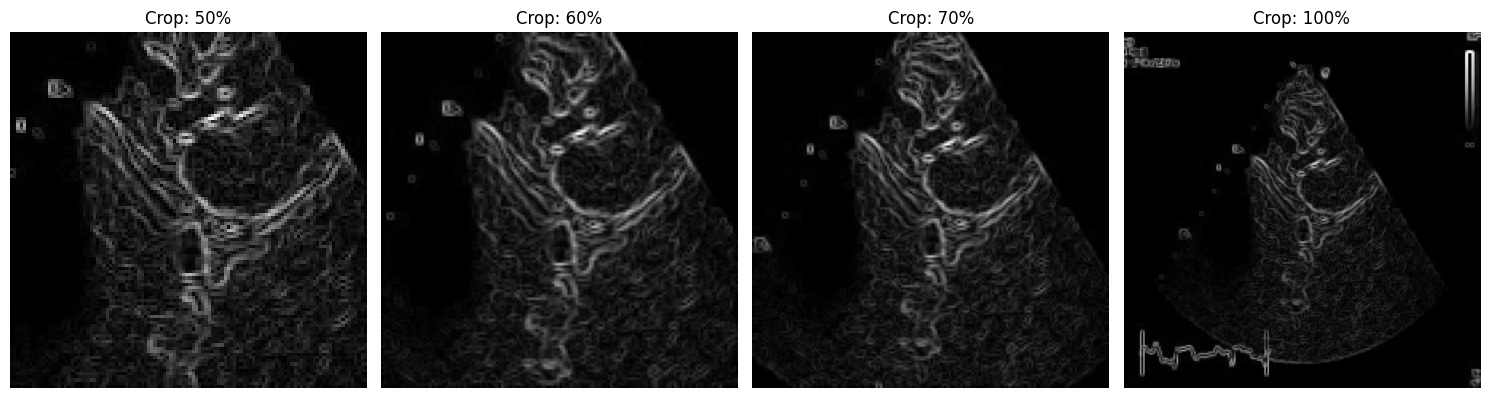

In [85]:
# Load the image
image_path = "/content/annotations/PLAX/processed_resized_224/12590890_98266974 _0052.dcm_slice_23.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Function to crop the center of the image
def center_crop(image, crop_width, crop_height):
    h, w, _ = image.shape
    start_x = (w - crop_width) // 2
    start_y = (h - crop_height) // 2
    return image[start_y:start_y+crop_height, start_x:start_x+crop_width]

# Sobel edge detection
def apply_sobel(image):
    """
    Apply Sobel edge detection to highlight edges in the image.
    """
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_combined = np.uint8(255 * sobel_combined / np.max(sobel_combined))
    return sobel_combined

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(3, 3)):
    """
    Apply CLAHE to enhance image contrast.
    """
    # Ensure the image is in grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

# Test different crop sizes
crop_percentages = [0.5, 0.6, 0.7, 1]  # Percentages of original dimensions
fig, axes = plt.subplots(1, len(crop_percentages), figsize=(15, 5))

for i, crop_percentage in enumerate(crop_percentages):
    crop_w = int(image.shape[1] * crop_percentage)
    crop_h = int(image.shape[0] * crop_percentage)
    cropped_image = center_crop(image, crop_w, crop_h)
    cropped_image = apply_clahe(cropped_image)
    cropped_image = apply_sobel(cropped_image)
    axes[i].imshow(cropped_image, cmap='gray')  # Use cmap='gray' for proper display of grayscale images
    axes[i].set_title(f"Crop: {int(crop_percentage * 100)}%")
    axes[i].axis("off")

plt.tight_layout()
plt.show()